# Лабораторна робота №3
# 31 варіант
## з дисципліни ІСППР
### виконав студент 3 курсу, групи КА-95, Петренко Микола¶

In [1]:
#importing libraries
import os
import shutil
import random
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from matplotlib import pyplot as plt
from matplotlib import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from keras.datasets import mnist
import warnings
from tqdm.notebook import tqdm, trange #progress bars
import cv2
%load_ext tensorboard

warnings.filterwarnings('ignore')

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#loading data
(train_X, train_y), (X_test, y_test) = mnist.load_data()

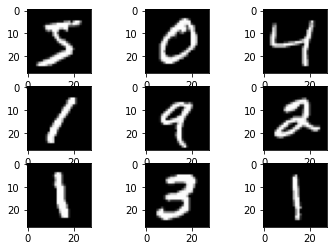

In [3]:
#some visualization
for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.imshow(train_X[i], cmap = plt.get_cmap('gray'))
plt.show()

In [4]:
#splitting initial training data into new train and validating datasets
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size = 0.2)

In [5]:
#reshaping our data in 2d array, each data point corresponds to 'brightness' of pixel on initial 28x28 image
X_train = X_train.reshape(len(X_train), 784) #784 = 28*28
X_valid = X_valid.reshape(len(X_valid), 784)
X_test = X_test.reshape(len(X_test), 784)

In [6]:
#normalising data (to range (0, 1)) for easier training
max_val = 255 #255 corresponds to 'brightest' pixel (white) so there is no value higher

X_train = X_train.astype('float64')
X_valid = X_valid.astype('float64')
X_test = X_test.astype('float64')

X_train /= max_val
X_valid /= max_val
X_test /= max_val

In [7]:
#converting labels to set of arrays with only zeroes and ones each of them corresponding to number from 0 to 9
num_classes = 10 #amount of numbers from 0 to 9

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# y_valid = np.argmax(y_valid, axis = 0)

In [8]:
np.unique(y_valid)

array([0., 1.], dtype=float32)

In [9]:
#example
y_train[0] #as we can see this array corresponds to 3 because it has 1 in fourth place

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [10]:
#model imputs
X = tf.placeholder(tf.float32, shape = [None, 784], name='x-input')
Y = tf.placeholder(tf.float32, shape = [None, 10], name='y-input')

In [11]:
#creating basic one layer model
def basic(x):
    logits = tf.compat.v1.layers.dense(inputs = x, units = 10, kernel_initializer = tf.random.normal)
    
    return logits

In [12]:
#creating deep model with multiple relu layers
def deep_relu(x):
    
    w1 = tf.compat.v1.get_variable(name = 'w1_relu', shape = [784, 256], initializer = tf.compat.v1.initializers.he_normal())
    b1 = tf.Variable(tf.zeros([256]))
    h1_ = tf.nn.relu(tf.matmul(x, w1) + b1)
    h1 = tf.compat.v1.layers.dropout(h1_, rate = 0.1)
    
    w2 = tf.compat.v1.get_variable(name = 'w2_relu', shape = [256, 128], initializer = tf.compat.v1.initializers.he_normal())
    b2 = tf.Variable(tf.zeros([128]))
    h2_ = tf.nn.relu(tf.matmul(h1, w2) + b2)
    h2 = tf.compat.v1.layers.dropout(h2_, rate = 0.1)

    w3 = tf.compat.v1.get_variable(name = 'w3_relu', shape = [128, 10], initializer = tf.compat.v1.initializers.he_normal())
    b3 = tf.Variable(tf.zeros([10]))
    logits_ = tf.matmul(h2, w3) + b3
    logits = tf.compat.v1.layers.dropout(logits_, rate = 0.1)
    
    return logits

In [13]:
#creating deep model with multiple tanh layers
def deep_tanh(x):
    
    w1 = tf.compat.v1.get_variable(name = 'w1_tanh', shape = [784, 256], initializer = tf.compat.v1.keras.initializers.glorot_normal(), regularizer = tf.keras.regularizers.L1())
    b1 = tf.Variable(tf.zeros([256]))
    h1 = tf.nn.tanh(tf.matmul(x, w1) + b1)
    
    w2 = tf.compat.v1.get_variable(name = 'w2_tanh', shape = [256, 128], initializer = tf.compat.v1.keras.initializers.glorot_normal(), regularizer = tf.keras.regularizers.L1())
    b2 = tf.Variable(tf.zeros([128]))
    h2 = tf.nn.tanh(tf.matmul(h1, w2) + b2)
    
    w3 = tf.compat.v1.get_variable(name = 'w3_tanh', shape = [128, 10], initializer = tf.compat.v1.keras.initializers.glorot_normal(), regularizer = tf.keras.regularizers.L1())
    b3 = tf.Variable(tf.zeros([10]))
    logits= tf.matmul(h2, w3) + b3
    
    return logits

In [14]:
#creating deep model with leaky_relu & elu layers
def relu_var(x):
    
    w1 = tf.compat.v1.get_variable(name = 'w1_var_relu', shape = [784, 256], initializer = tf.compat.v1.initializers.he_normal(), regularizer = tf.keras.regularizers.L1())
    b1 = tf.Variable(tf.zeros([256]))
    h1 = tf.nn.leaky_relu(tf.matmul(x, w1) + b1)
    
    w2 = tf.compat.v1.get_variable(name = 'w2_var_relu', shape = [256, 128], initializer = tf.compat.v1.initializers.he_normal(), regularizer = tf.keras.regularizers.L1())
    b2 = tf.Variable(tf.zeros([128]))
    h2 = tf.nn.elu(tf.matmul(h1, w2) + b2)
    
    w3 = tf.compat.v1.get_variable(name = 'w3_var_relu', shape = [128, 10], initializer = tf.compat.v1.initializers.he_normal(), regularizer = tf.keras.regularizers.L1())
    b3 = tf.Variable(tf.zeros([10]))
    logits= tf.matmul(h2, w3) + b3
    
    return logits

In [15]:
#creating deep model with multiple tanh layers & batch normalization
def deep_tanh_norm(x):
    
    bn0 = tf.compat.v1.layers.BatchNormalization()
    x = bn0.apply(x)
    
    bn1 = tf.compat.v1.layers.BatchNormalization()
    w1 = tf.compat.v1.get_variable(name = 'w1_tanh_norm', shape = [784, 256], initializer = tf.compat.v1.keras.initializers.glorot_normal())
    b1 = tf.Variable(tf.zeros([256]))
    h1_ = tf.nn.tanh(tf.matmul(x, w1) + b1)
    h1 = bn1.apply(h1_)
    
    bn2 = tf.compat.v1.layers.BatchNormalization()
    w2 = tf.compat.v1.get_variable(name = 'w2_tanh_norm', shape = [256, 128], initializer = tf.compat.v1.keras.initializers.glorot_normal())
    b2 = tf.Variable(tf.zeros([128]))
    h2_ = tf.nn.tanh(tf.matmul(h1, w2) + b2)
    h2 = bn2.apply(h2_)
    
    bn3 = tf.compat.v1.layers.BatchNormalization()
    w3 = tf.compat.v1.get_variable(name = 'w3_tanh_norm', shape = [128, 10], initializer = tf.compat.v1.keras.initializers.glorot_normal())
    b3 = tf.Variable(tf.zeros([10]))
    logits_ = tf.matmul(h2, w3) + b3
    logits = bn3.apply(logits_)
    
    return logits

In [16]:
#getting logits
model1 = basic(X)

In [17]:
#getting logits
model2 = deep_relu(X)

In [18]:
#getting logits
model3 = deep_tanh(X)

In [19]:
#getting logits
model4 = relu_var(X)

In [20]:
#getting logits
model5 = deep_tanh_norm(X)

In [21]:
#defining hyperparameters
learning_rate_list = [0.01, 0.02, 0.03, 0.04, 0.05]
epoch = 50
batch_size = 1000
iteration = len(X_train) // batch_size

In [22]:
saver = tf.train.Saver()

correct_prediction1 = tf.equal(tf.argmax(tf.nn.softmax(model1), 1), tf.argmax(Y, 1))
correct_prediction2 = tf.equal(tf.argmax(tf.nn.softmax(model2), 1), tf.argmax(Y, 1))
correct_prediction3 = tf.equal(tf.argmax(tf.nn.softmax(model3), 1), tf.argmax(Y, 1))
correct_prediction4 = tf.equal(tf.argmax(tf.nn.softmax(model4), 1), tf.argmax(Y, 1))
correct_prediction5 = tf.equal(tf.argmax(tf.nn.softmax(model5), 1), tf.argmax(Y, 1))

accuracy1 = tf.reduce_mean(tf.cast(correct_prediction1, "float"))
accuracy2 = tf.reduce_mean(tf.cast(correct_prediction2, "float"))
accuracy3 = tf.reduce_mean(tf.cast(correct_prediction3, "float"))
accuracy4 = tf.reduce_mean(tf.cast(correct_prediction4, "float"))
accuracy5 = tf.reduce_mean(tf.cast(correct_prediction5, "float"))

In [23]:
# creating dataframes to save training records
training_log11 = pd.DataFrame(index = ['Accuracy on validation data', 'Average loss', 'Learning rate'])
training_log12 = pd.DataFrame(index = ['Accuracy on validation data', 'Average loss', 'Learning rate'])
training_log13 = pd.DataFrame(index = ['Accuracy on validation data', 'Average loss', 'Learning rate'])
training_log14 = pd.DataFrame(index = ['Accuracy on validation data', 'Average loss', 'Learning rate'])

training_log21 = pd.DataFrame(index = ['Accuracy on validation data', 'Average loss', 'Learning rate'])
training_log22 = pd.DataFrame(index = ['Accuracy on validation data', 'Average loss', 'Learning rate'])
training_log23 = pd.DataFrame(index = ['Accuracy on validation data', 'Average loss', 'Learning rate'])
training_log24 = pd.DataFrame(index = ['Accuracy on validation data', 'Average loss', 'Learning rate'])

training_log31 = pd.DataFrame(index = ['Accuracy on validation data', 'Average loss', 'Learning rate'])
training_log32 = pd.DataFrame(index = ['Accuracy on validation data', 'Average loss', 'Learning rate'])
training_log33 = pd.DataFrame(index = ['Accuracy on validation data', 'Average loss', 'Learning rate'])
training_log34 = pd.DataFrame(index = ['Accuracy on validation data', 'Average loss', 'Learning rate'])

training_log41 = pd.DataFrame(index = ['Accuracy on validation data', 'Average loss', 'Learning rate'])
training_log42 = pd.DataFrame(index = ['Accuracy on validation data', 'Average loss', 'Learning rate'])
training_log43 = pd.DataFrame(index = ['Accuracy on validation data', 'Average loss', 'Learning rate'])
training_log44 = pd.DataFrame(index = ['Accuracy on validation data', 'Average loss', 'Learning rate'])

training_log51 = pd.DataFrame(index = ['Accuracy on validation data', 'Average loss', 'Learning rate'])
training_log52 = pd.DataFrame(index = ['Accuracy on validation data', 'Average loss', 'Learning rate'])
training_log53 = pd.DataFrame(index = ['Accuracy on validation data', 'Average loss', 'Learning rate'])
training_log54 = pd.DataFrame(index = ['Accuracy on validation data', 'Average loss', 'Learning rate'])

scores = pd.DataFrame(index = ['F1', 'AUC', 'Validation accuracy'])

In [24]:
# #cleaning directory with previous tensorboard logs
# tbdir = './tblogs'

# for filename in os.listdir(tbdir):
#     file_path = os.path.join(tbdir, filename)
#     try:
#         if os.path.isfile(file_path) or os.path.islink(file_path):
#             os.unlink(file_path)
#         elif os.path.isdir(file_path):
#             shutil.rmtree(file_path)
#     except Exception as e:
#         print('Failed to delete %s. Reason: %s' % (file_path, e))

In [25]:
# training model1 with Adam optimizer & MSE cost
j = 1

acc_summary = tf.summary.scalar('Accuracy_summary_for_model1_with_Adam_optimizer_and_MSE_cost', accuracy1)
cost = tf.reduce_mean(tf.square(model1 - Y))
loss_summary = tf.summary.scalar('Loss_summary_for_model1_with_Adam_optimizer_and_MSE_cost', cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for lr in learning_rate_list:
    optimizer = tf.compat.v1.train.AdamOptimizer(lr).minimize(cost)    
    init = tf.global_variables_initializer()
    
    print('Training model. Current learning rate: {:.2f}'.format(lr))
    
    outer_lvl = list(range(epoch))
     
    with tf.Session() as sess:
        
        writer1 = tf.summary.FileWriter('tblogs/model1/adam-mse/lr0.01', sess.graph)
        writer2 = tf.summary.FileWriter('tblogs/model1/adam-mse/lr0.02', sess.graph)
        writer3 = tf.summary.FileWriter('tblogs/model1/adam-mse/lr0.03', sess.graph)
        writer4 = tf.summary.FileWriter('tblogs/model1/adam-mse/lr0.04', sess.graph)
        writer5 = tf.summary.FileWriter('tblogs/model1/adam-mse/lr0.05', sess.graph)
        
        sess.run(init)
        for k in tqdm(outer_lvl, desc = 'Epoch progress'):
            avg_loss = 0.
            start = 0; end = batch_size
        
            for i in range(iteration):
                _, loss, summary = sess.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], Y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / iteration
                
            # # save_path   = saver.save(sess, 'model1-adam-mse-lr{}'.format(lr), write_meta_graph = False, write_state = False)                                
            cur_val_acc, summary = sess.run([accuracy1, merged], feed_dict = {X: X_valid, Y: y_valid})
            
            if lr == 0.01:
                writer1.add_summary(summary, k)
            elif lr == 0.02:
                writer2.add_summary(summary, k)
            elif lr == 0.03:
                writer3.add_summary(summary, k)
            elif lr == 0.04:
                writer4.add_summary(summary, k)
            else:
                writer5.add_summary(summary, k)
            
        training_log11['Fit №' + str(learning_rate_list.index(lr) + 1)] = [cur_val_acc, avg_loss, lr]
        
        j += 1

Training model. Current learning rate: 0.01


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.02


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.03


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.04


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.05


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [26]:
#results
# training_log11

In [27]:
with tf.Session() as sess:
    saver.restore(sess, 'model1-adam-mse-lr0.02')
    preds = tf.nn.softmax(model1)
    preds_val = preds.eval({X: X_valid, Y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scores['model1-adam-mse'] = [f1_score(y_valid, preds_val, average = 'macro'), roc_auc_score(y_valid, preds_val, multi_class = 'ovr', average = 'macro'), accuracy1.eval({X: X_valid, Y: y_valid})]

INFO:tensorflow:Restoring parameters from model1-adam-mse-lr0.02


In [28]:
# training model1 with gradient descent optimizer & MSE cost
j = 1

acc_summary = tf.summary.scalar('Accuracy_summary_for_model1_with_Gradient_Descent_optimizer_and_MSE_cost', accuracy1)
cost = tf.reduce_mean(tf.square(model1 - Y))
loss_summary = tf.summary.scalar('Loss_summary_for_model1_with_Gradient_Descent_optimizer_and_MSE_cost', cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for lr in learning_rate_list:
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(lr).minimize(cost)    
    init = tf.global_variables_initializer()
    print('Training model. Current learning rate: {:.2f}'.format(lr))
    
    outer_lvl = list(range(epoch))
    
    with tf.Session() as sess:
        
        writer1 = tf.summary.FileWriter('tblogs/model1/graddesc-mse/lr0.01', sess.graph)
        writer2 = tf.summary.FileWriter('tblogs/model1/graddesc-mse/lr0.02', sess.graph)
        writer3 = tf.summary.FileWriter('tblogs/model1/graddesc-mse/lr0.03', sess.graph)
        writer4 = tf.summary.FileWriter('tblogs/model1/graddesc-mse/lr0.04', sess.graph)
        writer5 = tf.summary.FileWriter('tblogs/model1/graddesc-mse/lr0.05', sess.graph)
        
        sess.run(init)
        for k in tqdm(outer_lvl, desc = 'Epoch progress'):
            avg_loss = 0.
            start = 0; end = batch_size
        
            for i in range(iteration):
                _, loss, summary = sess.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], Y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / iteration
            
            # save_path  = saver.save(sess, 'model1-graddesc-mse-lr{}'.format(lr), write_meta_graph = False, write_state = False)                            
            cur_val_acc, summary = sess.run([accuracy1, merged], feed_dict = {X: X_valid, Y: y_valid})
            
            if lr == 0.01:
                writer1.add_summary(summary, k)
            elif lr == 0.02:
                writer2.add_summary(summary, k)
            elif lr == 0.03:
                writer3.add_summary(summary, k)
            elif lr == 0.04:
                writer4.add_summary(summary, k)
            else:
                writer5.add_summary(summary, k)
                
        training_log12['Fit №' + str(learning_rate_list.index(lr) + 1)] = [cur_val_acc, avg_loss, lr]

        j += 1

Training model. Current learning rate: 0.01


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.02


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.03


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.04


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.05


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [29]:
#results
# training_log12

In [30]:
with tf.Session() as sess:
    saver.restore(sess, 'model1-graddesc-mse-lr0.05')
    preds = tf.nn.softmax(model1)
    preds_val = preds.eval({X: X_valid, Y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scores['model1-graddesc-mse'] = [f1_score(y_valid, preds_val, average = 'macro'), roc_auc_score(y_valid, preds_val, multi_class = 'ovr', average = 'macro'), accuracy1.eval({X: X_valid, Y: y_valid})]

INFO:tensorflow:Restoring parameters from model1-graddesc-mse-lr0.05


In [31]:
# training model1 with gradient descent optimizer & cross entropy cost
j = 1

acc_summary = tf.summary.scalar('Accuracy_summary_for_model1_with_Gradient_Descent_optimizer_and_Cross_entropy_cost', accuracy1)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = model1, labels = Y))
loss_summary = tf.summary.scalar('Loss_summary_for_model1_with_Gradient_Descent_optimizer_and_Cross_entropy_cost', cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for lr in learning_rate_list:
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(lr).minimize(cost)    
    init = tf.global_variables_initializer()
    
    print('Training model. Current learning rate: {:.2f}'.format(lr))
    
    outer_lvl = list(range(epoch))
    
    with tf.Session() as sess:
        
        writer1 = tf.summary.FileWriter('tblogs/model1/graddesc-crossentr/lr0.01', sess.graph)
        writer2 = tf.summary.FileWriter('tblogs/model1/graddesc-crossentr/lr0.02', sess.graph)
        writer3 = tf.summary.FileWriter('tblogs/model1/graddesc-crossentr/lr0.03', sess.graph)
        writer4 = tf.summary.FileWriter('tblogs/model1/graddesc-crossentr/lr0.04', sess.graph)
        writer5 = tf.summary.FileWriter('tblogs/model1/graddesc-crossentr/lr0.05', sess.graph)
        
        sess.run(init)
        for k in tqdm(outer_lvl, desc = 'Epoch progress'):
            avg_loss = 0.
            start = 0; end = batch_size
        
            for i in range(iteration):
                _, loss, summary = sess.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], Y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / iteration
            
            # save_path  = saver.save(sess, 'model1-graddesc-crossentr-lr{}'.format(lr), write_meta_graph = False, write_state = False)                            
            cur_val_acc, summary = sess.run([accuracy1, merged], feed_dict = {X: X_valid, Y: y_valid})
            
            if lr == 0.01:
                writer1.add_summary(summary, k)
            elif lr == 0.02:
                writer2.add_summary(summary, k)
            elif lr == 0.03:
                writer3.add_summary(summary, k)
            elif lr == 0.04:
                writer4.add_summary(summary, k)
            else:
                writer5.add_summary(summary, k)
        
        training_log13['Fit №' + str(learning_rate_list.index(lr) + 1)] = [cur_val_acc, avg_loss, lr]
        j += 1

Training model. Current learning rate: 0.01


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.02


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.03


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.04


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.05


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [32]:
#results
# training_log13

In [33]:
with tf.Session() as sess:
    saver.restore(sess, 'model1-graddesc-crossentr-lr0.05')
    preds = tf.nn.softmax(model1)
    preds_val = preds.eval({X: X_valid, Y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scores['model1-graddesc-crossentr'] = [f1_score(y_valid, preds_val, average = 'macro'), roc_auc_score(y_valid, preds_val, multi_class = 'ovr', average = 'macro'), accuracy1.eval({X: X_valid, Y: y_valid})]

INFO:tensorflow:Restoring parameters from model1-graddesc-crossentr-lr0.05


In [34]:
# training model1 with Adam optimizer & cross entropy cost
j = 1

acc_summary = tf.summary.scalar('Accuracy_summary_for_model1_with_Adam_optimizer_and_Cross_entropy_cost', accuracy1)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = model1, labels = Y))
loss_summary = tf.summary.scalar('Loss_summary_for_model1_with_Adam_optimizer_and_Cross_entropy_cost', cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for lr in learning_rate_list:
    optimizer = tf.compat.v1.train.AdamOptimizer(lr).minimize(cost)    
    init = tf.global_variables_initializer()
    
    print('Training model. Current learning rate: {:.2f}'.format(lr))
    
    outer_lvl = list(range(epoch))
    
    with tf.Session() as sess:
        
        writer1 = tf.summary.FileWriter('tblogs/model1/adam-crossentr/lr0.01', sess.graph)
        writer2 = tf.summary.FileWriter('tblogs/model1/adam-crossentr/lr0.02', sess.graph)
        writer3 = tf.summary.FileWriter('tblogs/model1/adam-crossentr/lr0.03', sess.graph)
        writer4 = tf.summary.FileWriter('tblogs/model1/adam-crossentr/lr0.04', sess.graph)
        writer5 = tf.summary.FileWriter('tblogs/model1/adam-crossentr/lr0.05', sess.graph)
        
        sess.run(init)
        for k in tqdm(outer_lvl, desc = 'Epoch progress'):
            avg_loss = 0.
            start = 0; end = batch_size
        
            for i in range(iteration):
                _, loss, summary = sess.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], Y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / iteration
                
            # save_path  = saver.save(sess, 'model1-adam-crossentr-lr{}'.format(lr), write_meta_graph = False, write_state = False)                            
            cur_val_acc, summary = sess.run([accuracy1, merged], feed_dict = {X: X_valid, Y: y_valid})
            
            if lr == 0.01:
                writer1.add_summary(summary, k)
            elif lr == 0.02:
                writer2.add_summary(summary, k)
            elif lr == 0.03:
                writer3.add_summary(summary, k)
            elif lr == 0.04:
                writer4.add_summary(summary, k)
            else:
                writer5.add_summary(summary, k)
                
        training_log14['Fit №' + str(learning_rate_list.index(lr) + 1)] = [cur_val_acc, avg_loss, lr]
        j += 1

Training model. Current learning rate: 0.01


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.02


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.03


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.04


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.05


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [35]:
#results
# training_log14

In [36]:
with tf.Session() as sess:
    saver.restore(sess, 'model1-adam-crossentr-lr0.02')
    preds = tf.nn.softmax(model1)
    preds_val = preds.eval({X: X_valid, Y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scores['model1-adam-crossentr'] = [f1_score(y_valid, preds_val, average = 'macro'), roc_auc_score(y_valid, preds_val, multi_class = 'ovr', average = 'macro'), accuracy1.eval({X: X_valid, Y: y_valid})]

INFO:tensorflow:Restoring parameters from model1-adam-crossentr-lr0.02


In [37]:
# training model2 with Adam optimizer & MSE cost
best_params21 = pd.DataFrame(index = ['Accuracy on validation data', 'Average loss', 'Learning rate', 'Optimizer', 'Cost function'])
j = 1

acc_summary = tf.summary.scalar('Accuracy_summary_for_model2_with_Adam_optimizer_and_MSE_cost', accuracy2)
cost = tf.reduce_mean(tf.square(model2 - Y))
loss_summary = tf.summary.scalar('Loss_summary_for_model2_with_Adam_optimizer_and_MSE_cost', cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for lr in learning_rate_list:
    optimizer = tf.compat.v1.train.AdamOptimizer(lr).minimize(cost)    
    init = tf.global_variables_initializer()
    
    print('Training model. Current learning rate: {:.2f}'.format(lr))
    
    outer_lvl = list(range(epoch))
     
    with tf.Session() as sess:
        
        writer1 = tf.summary.FileWriter('tblogs/model2/adam-mse/lr0.01', sess.graph)
        writer2 = tf.summary.FileWriter('tblogs/model2/adam-mse/lr0.02', sess.graph)
        writer3 = tf.summary.FileWriter('tblogs/model2/adam-mse/lr0.03', sess.graph)
        writer4 = tf.summary.FileWriter('tblogs/model2/adam-mse/lr0.04', sess.graph)
        writer5 = tf.summary.FileWriter('tblogs/model2/adam-mse/lr0.05', sess.graph)
        
        sess.run(init)
        for k in tqdm(outer_lvl, desc = 'Epoch progress'):
            avg_loss = 0.
            start = 0; end = batch_size
        
            for i in range(iteration):
                _, loss, summary = sess.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], Y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / iteration
                            
            # save_path  = saver.save(sess, 'model2-adam-mse-lr{}'.format(lr), write_meta_graph = False, write_state = False)                            
            cur_val_acc, summary = sess.run([accuracy2, merged], feed_dict = {X: X_valid, Y: y_valid})
            
            if lr == 0.01:
                writer1.add_summary(summary, k)
            elif lr == 0.02:
                writer2.add_summary(summary, k)
            elif lr == 0.03:
                writer3.add_summary(summary, k)
            elif lr == 0.04:
                writer4.add_summary(summary, k)
            else:
                writer5.add_summary(summary, k)
                
        training_log21['Fit №' + str(learning_rate_list.index(lr) + 1)] = [cur_val_acc, avg_loss, lr]
        j += 1
           
for col in training_log21.columns:
    if training_log21[col].loc['Average loss'] == training_log21.loc['Average loss'].values.min():
        best_params21['Model 2'] = [training_log21[col].values[0], training_log21[col].values[1], training_log21[col].values[2], 'Adam', 'MSE']

Training model. Current learning rate: 0.01


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.02


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.03


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.04


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.05


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [38]:
#results
# training_log21

In [39]:
with tf.Session() as sess:
    saver.restore(sess, 'model2-adam-mse-lr0.01')
    preds = tf.nn.softmax(model2)
    preds_val = preds.eval({X: X_valid, Y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scores['model2-adam-mse'] = [f1_score(y_valid, preds_val, average = 'macro'), roc_auc_score(y_valid, preds_val, multi_class = 'ovr', average = 'macro'), accuracy2.eval({X: X_valid, Y: y_valid})]

INFO:tensorflow:Restoring parameters from model2-adam-mse-lr0.01


In [40]:
# training model2 with gradient descent optimizer & MSE cost
j = 1

acc_summary = tf.summary.scalar('Accuracy_summary_for_model2_with_Gradient_Descent_optimizer_and_MSE_cost', accuracy2)
cost = tf.reduce_mean(tf.square(model2 - Y))
loss_summary = tf.summary.scalar('Loss_summary_for_model2_with_Gradient_Descent_optimizer_and_MSE_cost', cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for lr in learning_rate_list:
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(lr).minimize(cost)    
    init = tf.global_variables_initializer()
    print('Training model. Current learning rate: {:.2f}'.format(lr))
    
    outer_lvl = list(range(epoch))
    
    with tf.Session() as sess:
        
        writer1 = tf.summary.FileWriter('tblogs/model2/graddesc-mse/lr0.01', sess.graph)
        writer2 = tf.summary.FileWriter('tblogs/model2/graddesc-mse/lr0.02', sess.graph)
        writer3 = tf.summary.FileWriter('tblogs/model2/graddesc-mse/lr0.03', sess.graph)
        writer4 = tf.summary.FileWriter('tblogs/model2/graddesc-mse/lr0.04', sess.graph)
        writer5 = tf.summary.FileWriter('tblogs/model2/graddesc-mse/lr0.05', sess.graph)
        
        sess.run(init)
        for k in tqdm(outer_lvl, desc = 'Epoch progress'):
            avg_loss = 0.
            start = 0; end = batch_size
        
            for i in range(iteration):
                _, loss, summary = sess.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], Y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / iteration
            
            # save_path  = saver.save(sess, 'model2-graddesc-mse-lr{}'.format(lr), write_meta_graph = False, write_state = False)                            
            cur_val_acc, summary = sess.run([accuracy2, merged], feed_dict = {X: X_valid, Y: y_valid})
            
            if lr == 0.01:
                writer1.add_summary(summary, k)
            elif lr == 0.02:
                writer2.add_summary(summary, k)
            elif lr == 0.03:
                writer3.add_summary(summary, k)
            elif lr == 0.04:
                writer4.add_summary(summary, k)
            else:
                writer5.add_summary(summary, k)   
                
        training_log22['Fit №' + str(learning_rate_list.index(lr) + 1)] = [cur_val_acc, avg_loss, lr]
        j += 1

Training model. Current learning rate: 0.01


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.02


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.03


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.04


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.05


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [41]:
#results
# training_log22

In [42]:
with tf.Session() as sess:
    saver.restore(sess, 'model2-graddesc-mse-lr0.05')
    preds = tf.nn.softmax(model2)
    preds_val = preds.eval({X: X_valid, Y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scores['model2-graddesc-mse'] = [f1_score(y_valid, preds_val, average = 'macro'), roc_auc_score(y_valid, preds_val, multi_class = 'ovr', average = 'macro'), accuracy2.eval({X: X_valid, Y: y_valid})]

INFO:tensorflow:Restoring parameters from model2-graddesc-mse-lr0.05


In [43]:
# training model1 with gradient descent optimizer & cross entropy cost
j = 1

acc_summary = tf.summary.scalar('Accuracy_summary_for_model2_with_Gradient_Descent_optimizer_and_Cross_entropy_cost', accuracy2)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = model2, labels = Y))
loss_summary = tf.summary.scalar('Loss_summary_for_model2_with_Gradient_Descent_optimizer_and_Cross_entropy_cost', cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for lr in learning_rate_list:
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(lr).minimize(cost)    
    init = tf.global_variables_initializer()
    
    print('Training model. Current learning rate: {:.2f}'.format(lr))
    
    outer_lvl = list(range(epoch))
    
    with tf.Session() as sess:
        
        writer1 = tf.summary.FileWriter('tblogs/model2/graddesc-crossentr/lr0.01', sess.graph)
        writer2 = tf.summary.FileWriter('tblogs/model2/graddesc-crossentr/lr0.02', sess.graph)
        writer3 = tf.summary.FileWriter('tblogs/model2/graddesc-crossentr/lr0.03', sess.graph)
        writer4 = tf.summary.FileWriter('tblogs/model2/graddesc-crossentr/lr0.04', sess.graph)
        writer5 = tf.summary.FileWriter('tblogs/model2/graddesc-crossentr/lr0.05', sess.graph)
        
        sess.run(init)
        for k in tqdm(outer_lvl, desc = 'Epoch progress'):
            avg_loss = 0.
            start = 0; end = batch_size
        
            for i in range(iteration):
                _, loss, summary = sess.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], Y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / iteration
            
            # save_path  = saver.save(sess, 'model2-graddesc-crossentr-lr{}'.format(lr), write_meta_graph = False, write_state = False)                            
            cur_val_acc, summary = sess.run([accuracy2, merged], feed_dict = {X: X_valid, Y: y_valid})
            
            if lr == 0.01:
                writer1.add_summary(summary, k)
            elif lr == 0.02:
                writer2.add_summary(summary, k)
            elif lr == 0.03:
                writer3.add_summary(summary, k)
            elif lr == 0.04:
                writer4.add_summary(summary, k)
            else:
                writer5.add_summary(summary, k)
                
        training_log23['Fit №' + str(learning_rate_list.index(lr) + 1)] = [cur_val_acc, avg_loss, lr]
        j += 1

Training model. Current learning rate: 0.01


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.02


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.03


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.04


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.05


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [44]:
#results
# training_log23

In [45]:
with tf.Session() as sess:
    saver.restore(sess, 'model2-graddesc-crossentr-lr0.05')
    preds = tf.nn.softmax(model2)
    preds_val = preds.eval({X: X_valid, Y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scores['model2-graddesc-crossentr'] = [f1_score(y_valid, preds_val, average = 'macro'), roc_auc_score(y_valid, preds_val, multi_class = 'ovr', average = 'macro'), accuracy2.eval({X: X_valid, Y: y_valid})]

INFO:tensorflow:Restoring parameters from model2-graddesc-crossentr-lr0.05


In [46]:
# training model2 with Adam optimizer & cross entropy cost
j = 1

acc_summary = tf.summary.scalar('Accuracy_summary_for_model2_with_Adam_optimizer_and_Cross_entropy_cost', accuracy2)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = model2, labels = Y))
loss_summary = tf.summary.scalar('Loss_summary_for_model2_with_Adam_optimizer_and_Cross_entropy_cost', cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for lr in learning_rate_list:
    optimizer = tf.compat.v1.train.AdamOptimizer(lr).minimize(cost)    
    init = tf.global_variables_initializer()
    
    print('Training model. Current learning rate: {:.2f}'.format(lr))
    
    outer_lvl = list(range(epoch))
    
    with tf.Session() as sess:
        
        writer1 = tf.summary.FileWriter('tblogs/model2/adam-crossentr/lr0.01', sess.graph)
        writer2 = tf.summary.FileWriter('tblogs/model2/adam-crossentr/lr0.02', sess.graph)
        writer3 = tf.summary.FileWriter('tblogs/model2/adam-crossentr/lr0.03', sess.graph)
        writer4 = tf.summary.FileWriter('tblogs/model2/adam-crossentr/lr0.04', sess.graph)
        writer5 = tf.summary.FileWriter('tblogs/model2/adam-crossentr/lr0.05', sess.graph)
        
        sess.run(init)
        for k in tqdm(outer_lvl, desc = 'Epoch progress'):
            avg_loss = 0.
            start = 0; end = batch_size
        
            for i in range(iteration):
                _, loss, summary = sess.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], Y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / iteration
                
            # save_path  = saver.save(sess, 'model2-adam-crossentr-lr{}'.format(lr), write_meta_graph = False, write_state = False)                            
            cur_val_acc, summary = sess.run([accuracy2, merged], feed_dict = {X: X_valid, Y: y_valid})
            
            if lr == 0.01:
                writer1.add_summary(summary, k)
            elif lr == 0.02:
                writer2.add_summary(summary, k)
            elif lr == 0.03:
                writer3.add_summary(summary, k)
            elif lr == 0.04:
                writer4.add_summary(summary, k)
            else:
                writer5.add_summary(summary, k)
                
        training_log24['Fit №' + str(learning_rate_list.index(lr) + 1)] = [cur_val_acc, avg_loss, lr]
        j += 1

Training model. Current learning rate: 0.01


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.02


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.03


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.04


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.05


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [47]:
#results
# training_log24

In [48]:
with tf.Session() as sess:
    saver.restore(sess, 'model2-adam-crossentr-lr0.01')
    preds = tf.nn.softmax(model2)
    preds_val = preds.eval({X: X_valid, Y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scores['model2-adam-crossentr'] = [f1_score(y_valid, preds_val, average = 'macro'), roc_auc_score(y_valid, preds_val, multi_class = 'ovr', average = 'macro'), accuracy2.eval({X: X_valid, Y: y_valid})]

INFO:tensorflow:Restoring parameters from model2-adam-crossentr-lr0.01


In [53]:
# training model3 with Adam optimizer & MSE cost
j = 1

acc_summary = tf.summary.scalar('Accuracy_summary_for_model3_with_Adam_optimizer_and_MSE_cost', accuracy3)
cost = tf.reduce_mean(tf.square(model3 - Y))
loss_summary = tf.summary.scalar('Loss_summary_for_model3_with_Adam_optimizer_and_MSE_cost', cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for lr in learning_rate_list:
    optimizer = tf.compat.v1.train.AdamOptimizer(lr).minimize(cost)    
    init = tf.global_variables_initializer()
    
    print('Training model. Current learning rate: {:.2f}'.format(lr))
    
    outer_lvl = list(range(epoch))
     
    with tf.Session() as sess:
        
        writer1 = tf.summary.FileWriter('tblogs/model3/adam-mse/lr0.01', sess.graph)
        writer2 = tf.summary.FileWriter('tblogs/model3/adam-mse/lr0.02', sess.graph)
        writer3 = tf.summary.FileWriter('tblogs/model3/adam-mse/lr0.03', sess.graph)
        writer4 = tf.summary.FileWriter('tblogs/model3/adam-mse/lr0.04', sess.graph)
        writer5 = tf.summary.FileWriter('tblogs/model3/adam-mse/lr0.05', sess.graph)
        
        sess.run(init)
        for k in tqdm(outer_lvl, desc = 'Epoch progress'):
            avg_loss = 0.
            start = 0; end = batch_size
        
            for i in range(iteration):
                _, loss, summary = sess.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], Y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / iteration
                            
            # save_path  = saver.save(sess, 'model3-adam-mse-lr{}'.format(lr), write_meta_graph = False, write_state = False)                            
            cur_val_acc, summary = sess.run([accuracy3, merged], feed_dict = {X: X_valid, Y: y_valid})
            
            if lr == 0.01:
                writer1.add_summary(summary, k)
            elif lr == 0.02:
                writer2.add_summary(summary, k)
            elif lr == 0.03:
                writer3.add_summary(summary, k)
            elif lr == 0.04:
                writer4.add_summary(summary, k)
            else:
                writer5.add_summary(summary, k)
                
        training_log31['Fit №' + str(learning_rate_list.index(lr) + 1)] = [cur_val_acc, avg_loss, lr]
        j += 1

Training model. Current learning rate: 0.01


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:tensorflow:model3-adam-mse-lr0.01.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.01.data-00000-of-00001.tempstate6923177340213921996
INFO:tensorflow:7600
INFO:tensorflow:model3-adam-mse-lr0.01.index
INFO:tensorflow:7600
INFO:tensorflow:model3-adam-mse-lr0.01.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.01.data-00000-of-00001.tempstate6923177340213921996
INFO:tensorflow:7600
INFO:tensorflow:model3-adam-mse-lr0.01.index
INFO:tensorflow:7600
INFO:tensorflow:model3-adam-mse-lr0.01.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.01.data-00000-of-00001.tempstate6923177340213921996
INFO:tensorflow:7600
INFO:tensorflow:model3-adam-mse-lr0.01.index
INFO:tensorflow:7600
INFO:tensorflow:model3-adam-mse-lr0.01.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.01.data-00000-of-00001.tempstate6923177340213921996
INFO:tensorflow:7600
INFO:tensorflow:model3-adam-mse-lr0.01.index
I

Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:tensorflow:model3-adam-mse-lr0.02.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.02.index
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.02.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.02.index
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.02.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.02.index
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.02.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.02.index
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.02.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.02.index
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.02.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.02.index
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.02.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.02.index

Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:tensorflow:model3-adam-mse-lr0.03.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.03.index
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.03.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.03.index
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.03.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.03.index
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.03.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.03.index
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.03.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.03.index
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.03.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.03.index
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.03.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.03.index

Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:tensorflow:model3-adam-mse-lr0.04.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.04.index
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.04.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.04.index
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.04.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.04.index
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.04.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.04.index
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.04.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.04.index
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.04.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.04.index
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.04.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.04.index

Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:tensorflow:model3-adam-mse-lr0.05.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.05.index
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.05.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.05.index
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.05.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.05.index
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.05.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.05.index
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.05.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.05.index
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.05.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.05.index
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.05.data-00000-of-00001
INFO:tensorflow:3800
INFO:tensorflow:model3-adam-mse-lr0.05.index

In [54]:
#results
# training_log31

In [55]:
with tf.Session() as sess:
    saver.restore(sess, 'model3-adam-mse-lr0.01')
    preds = tf.nn.softmax(model3)
    preds_val = preds.eval({X: X_valid, Y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scores['model3-adam-mse'] = [f1_score(y_valid, preds_val, average = 'macro'), roc_auc_score(y_valid, preds_val, multi_class = 'ovr', average = 'macro'), accuracy3.eval({X: X_valid, Y: y_valid})]

INFO:tensorflow:Restoring parameters from model3-adam-mse-lr0.01


In [56]:
# training model3 with gradient descent optimizer & MSE cost
j = 1

acc_summary = tf.summary.scalar('Accuracy_summary_for_model3_with_Gradient_Descent_optimizer_and_MSE_cost', accuracy3)
cost = tf.reduce_mean(tf.square(model3 - Y))
loss_summary = tf.summary.scalar('Loss_summary_for_model3_with_Gradient_Descent_optimizer_and_MSE_cost', cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for lr in learning_rate_list:
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(lr).minimize(cost)    
    init = tf.global_variables_initializer()
    print('Training model. Current learning rate: {:.2f}'.format(lr))
    
    outer_lvl = list(range(epoch))
    
    with tf.Session() as sess:
        
        writer1 = tf.summary.FileWriter('tblogs/model3/graddesc-mse/lr0.01', sess.graph)
        writer2 = tf.summary.FileWriter('tblogs/model3/graddesc-mse/lr0.02', sess.graph)
        writer3 = tf.summary.FileWriter('tblogs/model3/graddesc-mse/lr0.03', sess.graph)
        writer4 = tf.summary.FileWriter('tblogs/model3/graddesc-mse/lr0.04', sess.graph)
        writer5 = tf.summary.FileWriter('tblogs/model3/graddesc-mse/lr0.05', sess.graph)
        
        sess.run(init)
        for k in tqdm(outer_lvl, desc = 'Epoch progress'):
            avg_loss = 0.
            start = 0; end = batch_size
        
            for i in range(iteration):
                _, loss, summary = sess.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], Y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / iteration
                            
            # save_path  = saver.save(sess, 'model3-graddesc-mse-lr{}'.format(lr), write_meta_graph = False, write_state = False)                            
            cur_val_acc, summary = sess.run([accuracy3, merged], feed_dict = {X: X_valid, Y: y_valid})
            
            if lr == 0.01:
                writer1.add_summary(summary, k)
            elif lr == 0.02:
                writer2.add_summary(summary, k)
            elif lr == 0.03:
                writer3.add_summary(summary, k)
            elif lr == 0.04:
                writer4.add_summary(summary, k)
            else:
                writer5.add_summary(summary, k)
                
        training_log32['Fit №' + str(learning_rate_list.index(lr) + 1)] = [cur_val_acc, avg_loss, lr]
        j += 1

Training model. Current learning rate: 0.01


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.02


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.03


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.04


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.05


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [57]:
#results
# training_log32

In [58]:
with tf.Session() as sess:
    saver.restore(sess, 'model3-graddesc-mse-lr0.05')
    preds = tf.nn.softmax(model3)
    preds_val = preds.eval({X: X_valid, Y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scores['model3-graddesc-mse'] = [f1_score(y_valid, preds_val, average = 'macro'), roc_auc_score(y_valid, preds_val, multi_class = 'ovr', average = 'macro'), accuracy3.eval({X: X_valid, Y: y_valid})]

INFO:tensorflow:Restoring parameters from model3-graddesc-mse-lr0.05


In [59]:
# training model3 with gradient descent optimizer & cross entropy cost
j = 1

acc_summary = tf.summary.scalar('Accuracy_summary_for_model3_with_Gradient_Descent_optimizer_and_Cross_entropy_cost', accuracy3)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = model3, labels = Y))
loss_summary = tf.summary.scalar('Loss_summary_for_model3_with_Gradient_Descent_optimizer_and_Cross_entropy_cost', cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for lr in learning_rate_list:
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(lr).minimize(cost)    
    init = tf.global_variables_initializer()
    
    print('Training model. Current learning rate: {:.2f}'.format(lr))
    
    outer_lvl = list(range(epoch))
    
    with tf.Session() as sess:
        
        writer1 = tf.summary.FileWriter('tblogs/model3/graddesc-crossentr/lr0.01', sess.graph)
        writer2 = tf.summary.FileWriter('tblogs/model3/graddesc-crossentr/lr0.02', sess.graph)
        writer3 = tf.summary.FileWriter('tblogs/model3/graddesc-crossentr/lr0.03', sess.graph)
        writer4 = tf.summary.FileWriter('tblogs/model3/graddesc-crossentr/lr0.04', sess.graph)
        writer5 = tf.summary.FileWriter('tblogs/model3/graddesc-crossentr/lr0.05', sess.graph)
        
        sess.run(init)
        for k in tqdm(outer_lvl, desc = 'Epoch progress'):
            avg_loss = 0.
            start = 0; end = batch_size
        
            for i in range(iteration):
                _, loss, summary = sess.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], Y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / iteration
                
            # save_path  = saver.save(sess, 'model3-graddesc-crossentr-lr{}'.format(lr), write_meta_graph = False, write_state = False)                            
            cur_val_acc, summary = sess.run([accuracy3, merged], feed_dict = {X: X_valid, Y: y_valid})
            
            if lr == 0.01:
                writer1.add_summary(summary, k)
            elif lr == 0.02:
                writer2.add_summary(summary, k)
            elif lr == 0.03:
                writer3.add_summary(summary, k)
            elif lr == 0.04:
                writer4.add_summary(summary, k)
            else:
                writer5.add_summary(summary, k)
                
        training_log33['Fit №' + str(learning_rate_list.index(lr) + 1)] = [cur_val_acc, avg_loss, lr]
        j += 1

Training model. Current learning rate: 0.01


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.02


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.03


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.04


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.05


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [60]:
#results
# training_log33

In [61]:
with tf.Session() as sess:
    saver.restore(sess, 'model3-graddesc-crossentr-lr0.05')
    preds = tf.nn.softmax(model3)
    preds_val = preds.eval({X: X_valid, Y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scores['model3-graddesc-crossentr'] = [f1_score(y_valid, preds_val, average = 'macro'), roc_auc_score(y_valid, preds_val, multi_class = 'ovr', average = 'macro'), accuracy3.eval({X: X_valid, Y: y_valid})]

INFO:tensorflow:Restoring parameters from model3-graddesc-crossentr-lr0.05


In [62]:
# training model3 with Adam optimizer & cross entopy cost
j = 1

acc_summary = tf.summary.scalar('Accuracy_summary_for_model3_with_Adam_optimizer_and_Cross_entropy_cost', accuracy3)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = model3, labels = Y))
loss_summary = tf.summary.scalar('Loss_summary_for_model3_with_Adam_optimizer_and_Cross_entropy_cost', cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for lr in learning_rate_list:
    optimizer = tf.compat.v1.train.AdamOptimizer(lr).minimize(cost)    
    init = tf.global_variables_initializer()
    
    print('Training model. Current learning rate: {:.2f}'.format(lr))
    
    outer_lvl = list(range(epoch))
    
    with tf.Session() as sess:
        
        writer1 = tf.summary.FileWriter('tblogs/model3/adam-crossentr/lr0.01', sess.graph)
        writer2 = tf.summary.FileWriter('tblogs/model3/adam-crossentr/lr0.02', sess.graph)
        writer3 = tf.summary.FileWriter('tblogs/model3/adam-crossentr/lr0.03', sess.graph)
        writer4 = tf.summary.FileWriter('tblogs/model3/adam-crossentr/lr0.04', sess.graph)
        writer5 = tf.summary.FileWriter('tblogs/model3/adam-crossentr/lr0.05', sess.graph)
        
        sess.run(init)
        for k in tqdm(outer_lvl, desc = 'Epoch progress'):
            avg_loss = 0.
            start = 0; end = batch_size
        
            for i in range(iteration):
                _, loss, summary = sess.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], Y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / iteration
                
            # save_path  = saver.save(sess, 'model3-adam-crossentr-lr{}'.format(lr), write_meta_graph = False, write_state = False)                            
            cur_val_acc, summary = sess.run([accuracy3, merged], feed_dict = {X: X_valid, Y: y_valid})
            
            if lr == 0.01:
                writer1.add_summary(summary, k)
            elif lr == 0.02:
                writer2.add_summary(summary, k)
            elif lr == 0.03:
                writer3.add_summary(summary, k)
            elif lr == 0.04:
                writer4.add_summary(summary, k)
            else:
                writer5.add_summary(summary, k)
                
        training_log34['Fit №' + str(learning_rate_list.index(lr) + 1)] = [cur_val_acc, avg_loss, lr]
        j += 1

Training model. Current learning rate: 0.01


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.02


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.03


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.04


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.05


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [63]:
#results
# training_log34

In [64]:
with tf.Session() as sess:
    saver.restore(sess, 'model3-adam-crossentr-lr0.01')
    preds = tf.nn.softmax(model3)
    preds_val = preds.eval({X: X_valid, Y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scores['model3-adam-crossentr'] = [f1_score(y_valid, preds_val, average = 'macro'), roc_auc_score(y_valid, preds_val, multi_class = 'ovr', average = 'macro'), accuracy3.eval({X: X_valid, Y: y_valid})]

INFO:tensorflow:Restoring parameters from model3-adam-crossentr-lr0.01


In [65]:
# training model4 with Adam optimizer & MSE cost
j = 1

acc_summary = tf.summary.scalar('Accuracy_summary_for_model4_with_Adam_optimizer_and_MSE_cost', accuracy4)
cost = tf.reduce_mean(tf.square(model4 - Y))
loss_summary = tf.summary.scalar('Loss_summary_for_model4_with_Adam_optimizer_and_MSE_cost', cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for lr in learning_rate_list:
    optimizer = tf.compat.v1.train.AdamOptimizer(lr).minimize(cost)    
    init = tf.global_variables_initializer()
    
    print('Training model. Current learning rate: {:.2f}'.format(lr))
    
    outer_lvl = list(range(epoch))
     
    with tf.Session() as sess:
        
        writer1 = tf.summary.FileWriter('tblogs/model4/adam-mse/lr0.01', sess.graph)
        writer2 = tf.summary.FileWriter('tblogs/model4/adam-mse/lr0.02', sess.graph)
        writer3 = tf.summary.FileWriter('tblogs/model4/adam-mse/lr0.03', sess.graph)
        writer4 = tf.summary.FileWriter('tblogs/model4/adam-mse/lr0.04', sess.graph)
        writer5 = tf.summary.FileWriter('tblogs/model4/adam-mse/lr0.05', sess.graph)
        
        sess.run(init)
        for k in tqdm(outer_lvl, desc = 'Epoch progress'):
            avg_loss = 0.
            start = 0; end = batch_size
        
            for i in range(iteration):
                _, loss, summary = sess.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], Y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / iteration
                            
            # save_path  = saver.save(sess, 'model4-adam-mse-lr{}'.format(lr), write_meta_graph = False, write_state = False)                            
            cur_val_acc, summary = sess.run([accuracy4, merged], feed_dict = {X: X_valid, Y: y_valid})
            
            if lr == 0.01:
                writer1.add_summary(summary, k)
            elif lr == 0.02:
                writer2.add_summary(summary, k)
            elif lr == 0.03:
                writer3.add_summary(summary, k)
            elif lr == 0.04:
                writer4.add_summary(summary, k)
            else:
                writer5.add_summary(summary, k)
            
        training_log41['Fit №' + str(learning_rate_list.index(lr) + 1)] = [cur_val_acc, avg_loss, lr]
        
        j += 1

Training model. Current learning rate: 0.01


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.02


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.03


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.04


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.05


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [66]:
#results
# training_log41

In [67]:
with tf.Session() as sess:
    saver.restore(sess, 'model1-adam-mse-lr0.01')
    print("Test Accuracy :", accuracy4.eval({X: X_test, Y: y_test}))

INFO:tensorflow:Restoring parameters from model1-adam-mse-lr0.01
Test Accuracy : 0.0926


In [68]:
# training model4 with gradient descent optimizer & MSE cost
j = 1

acc_summary = tf.summary.scalar('Accuracy_summary_for_model4_with_Gradient_Descent_optimizer_and_MSE_cost', accuracy4)
cost = tf.reduce_mean(tf.square(model4 - Y))
loss_summary = tf.summary.scalar('Loss_summary_for_model4_with_Gradient_Descent_optimizer_and_MSE_cost', cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for lr in learning_rate_list:
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(lr).minimize(cost)    
    init = tf.global_variables_initializer()
    print('Training model. Current learning rate: {:.2f}'.format(lr))
    
    outer_lvl = list(range(epoch))
    
    with tf.Session() as sess:
        
        writer1 = tf.summary.FileWriter('tblogs/model4/graddesc-mse/lr0.01', sess.graph)
        writer2 = tf.summary.FileWriter('tblogs/model4/graddesc-mse/lr0.02', sess.graph)
        writer3 = tf.summary.FileWriter('tblogs/model4/graddesc-mse/lr0.03', sess.graph)
        writer4 = tf.summary.FileWriter('tblogs/model4/graddesc-mse/lr0.04', sess.graph)
        writer5 = tf.summary.FileWriter('tblogs/model4/graddesc-mse/lr0.05', sess.graph)
        
        sess.run(init)
        for k in tqdm(outer_lvl, desc = 'Epoch progress'):
            avg_loss = 0.
            start = 0; end = batch_size
        
            for i in range(iteration):
                _, loss, summary = sess.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], Y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / iteration
            
            # save_path  = saver.save(sess, 'model4-graddesc-mse-lr{}'.format(lr), write_meta_graph = False, write_state = False)                            
            cur_val_acc, summary = sess.run([accuracy4, merged], feed_dict = {X: X_valid, Y: y_valid})
            
            if lr == 0.01:
                writer1.add_summary(summary, k)
            elif lr == 0.02:
                writer2.add_summary(summary, k)
            elif lr == 0.03:
                writer3.add_summary(summary, k)
            elif lr == 0.04:
                writer4.add_summary(summary, k)
            else:
                writer5.add_summary(summary, k)
                
        training_log42['Fit №' + str(learning_rate_list.index(lr) + 1)] = [cur_val_acc, avg_loss, lr]

        j += 1

Training model. Current learning rate: 0.01


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.02


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.03


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.04


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.05


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [69]:
#results
# training_log42

In [70]:
with tf.Session() as sess:
    saver.restore(sess, 'model4-graddesc-mse-lr0.05')
    preds = tf.nn.softmax(model4)
    preds_val = preds.eval({X: X_valid, Y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scores['model4-graddesc-mse'] = [f1_score(y_valid, preds_val, average = 'macro'), roc_auc_score(y_valid, preds_val, multi_class = 'ovr', average = 'macro'), accuracy4.eval({X: X_valid, Y: y_valid})]

INFO:tensorflow:Restoring parameters from model4-graddesc-mse-lr0.05


In [71]:
# training model4 with gradient descent optimizer & cross entropy cost
j = 1

acc_summary = tf.summary.scalar('Accuracy_summary_for_model4_with_Gradient_Descent_optimizer_and_Cross_entropy_cost', accuracy4)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = model4, labels = Y))
loss_summary = tf.summary.scalar('Loss_summary_for_model4_with_Gradient_Descent_optimizer_and_Cross_entropy_cost', cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for lr in learning_rate_list:
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(lr).minimize(cost)    
    init = tf.global_variables_initializer()
    
    print('Training model. Current learning rate: {:.2f}'.format(lr))
    
    outer_lvl = list(range(epoch))
    
    with tf.Session() as sess:
        
        writer1 = tf.summary.FileWriter('tblogs/model4/graddesc-crossentr/lr0.01', sess.graph)
        writer2 = tf.summary.FileWriter('tblogs/model4/graddesc-crossentr/lr0.02', sess.graph)
        writer3 = tf.summary.FileWriter('tblogs/model4/graddesc-crossentr/lr0.03', sess.graph)
        writer4 = tf.summary.FileWriter('tblogs/model4/graddesc-crossentr/lr0.04', sess.graph)
        writer5 = tf.summary.FileWriter('tblogs/model4/graddesc-crossentr/lr0.05', sess.graph)
        
        sess.run(init)
        for k in tqdm(outer_lvl, desc = 'Epoch progress'):
            avg_loss = 0.
            start = 0; end = batch_size
        
            for i in range(iteration):
                _, loss, summary = sess.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], Y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / iteration
            
            # save_path  = saver.save(sess, 'model4-graddesc-crossentr-lr{}'.format(lr), write_meta_graph = False, write_state = False)                            
            cur_val_acc, summary = sess.run([accuracy4, merged], feed_dict = {X: X_valid, Y: y_valid})
            
            if lr == 0.01:
                writer1.add_summary(summary, k)
            elif lr == 0.02:
                writer2.add_summary(summary, k)
            elif lr == 0.03:
                writer3.add_summary(summary, k)
            elif lr == 0.04:
                writer4.add_summary(summary, k)
            else:
                writer5.add_summary(summary, k)
        
        training_log43['Fit №' + str(learning_rate_list.index(lr) + 1)] = [cur_val_acc, avg_loss, lr]
        j += 1

Training model. Current learning rate: 0.01


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.02


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.03


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.04


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.05


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [72]:
#results
# training_log43

In [73]:
with tf.Session() as sess:
    saver.restore(sess, 'model4-graddesc-crossentr-lr0.05')
    preds = tf.nn.softmax(model4)
    preds_val = preds.eval({X: X_valid, Y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scores['model4-graddesc-crossentr'] = [f1_score(y_valid, preds_val, average = 'macro'), roc_auc_score(y_valid, preds_val, multi_class = 'ovr', average = 'macro'), accuracy4.eval({X: X_valid, Y: y_valid})]

INFO:tensorflow:Restoring parameters from model4-graddesc-crossentr-lr0.05


In [74]:
# training model4 with Adam optimizer & cross entropy cost
j = 1

acc_summary = tf.summary.scalar('Accuracy_summary_for_model4_with_Adam_optimizer_and_Cross_entropy_cost', accuracy4)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = model4, labels = Y))
loss_summary = tf.summary.scalar('Loss_summary_for_model4_with_Adam_optimizer_and_Cross_entropy_cost', cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for lr in learning_rate_list:
    optimizer = tf.compat.v1.train.AdamOptimizer(lr).minimize(cost)    
    init = tf.global_variables_initializer()
    
    print('Training model. Current learning rate: {:.2f}'.format(lr))
    
    outer_lvl = list(range(epoch))
    
    with tf.Session() as sess:
        
        writer1 = tf.summary.FileWriter('tblogs/model4/adam-crossentr/lr0.01', sess.graph)
        writer2 = tf.summary.FileWriter('tblogs/model4/adam-crossentr/lr0.02', sess.graph)
        writer3 = tf.summary.FileWriter('tblogs/model4/adam-crossentr/lr0.03', sess.graph)
        writer4 = tf.summary.FileWriter('tblogs/model4/adam-crossentr/lr0.04', sess.graph)
        writer5 = tf.summary.FileWriter('tblogs/model4/adam-crossentr/lr0.05', sess.graph)
        
        sess.run(init)
        for k in tqdm(outer_lvl, desc = 'Epoch progress'):
            avg_loss = 0.
            start = 0; end = batch_size
        
            for i in range(iteration):
                _, loss, summary = sess.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], Y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / iteration
                
            # save_path  = saver.save(sess, 'model4-adam-crossentr-lr{}'.format(lr), write_meta_graph = False, write_state = False)                            
            cur_val_acc, summary = sess.run([accuracy4, merged], feed_dict = {X: X_valid, Y: y_valid})
            
            if lr == 0.01:
                writer1.add_summary(summary, k)
            elif lr == 0.02:
                writer2.add_summary(summary, k)
            elif lr == 0.03:
                writer3.add_summary(summary, k)
            elif lr == 0.04:
                writer4.add_summary(summary, k)
            else:
                writer5.add_summary(summary, k)
                
        training_log44['Fit №' + str(learning_rate_list.index(lr) + 1)] = [cur_val_acc, avg_loss, lr]
        j += 1

Training model. Current learning rate: 0.01


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.02


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.03


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.04


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.05


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [75]:
#results
# training_log44

In [76]:
with tf.Session() as sess:
    saver.restore(sess, 'model4-adam-crossentr-lr0.01')
    preds = tf.nn.softmax(model4)
    preds_val = preds.eval({X: X_valid, Y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scores['model4-adam-crossentr'] = [f1_score(y_valid, preds_val, average = 'macro'), roc_auc_score(y_valid, preds_val, multi_class = 'ovr', average = 'macro'), accuracy4.eval({X: X_valid, Y: y_valid})]

INFO:tensorflow:Restoring parameters from model4-adam-crossentr-lr0.01


In [77]:
# training model5 with Adam optimizer & MSE cost
j = 1

acc_summary = tf.summary.scalar('Accuracy_summary_for_model5_with_Adam_optimizer_and_MSE_cost', accuracy5)
cost = tf.reduce_mean(tf.square(model5 - Y))
loss_summary = tf.summary.scalar('Loss_summary_for_model5_with_Adam_optimizer_and_MSE_cost', cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for lr in learning_rate_list:
    optimizer = tf.compat.v1.train.AdamOptimizer(lr).minimize(cost)    
    init = tf.global_variables_initializer()
    
    print('Training model. Current learning rate: {:.2f}'.format(lr))
    
    outer_lvl = list(range(epoch))
     
    with tf.Session() as sess:
        
        writer1 = tf.summary.FileWriter('tblogs/model5/adam-mse/lr0.01', sess.graph)
        writer2 = tf.summary.FileWriter('tblogs/model5/adam-mse/lr0.02', sess.graph)
        writer3 = tf.summary.FileWriter('tblogs/model5/adam-mse/lr0.03', sess.graph)
        writer4 = tf.summary.FileWriter('tblogs/model5/adam-mse/lr0.04', sess.graph)
        writer5 = tf.summary.FileWriter('tblogs/model5/adam-mse/lr0.05', sess.graph)
        
        sess.run(init)
        for k in tqdm(outer_lvl, desc = 'Epoch progress'):
            avg_loss = 0.
            start = 0; end = batch_size
        
            for i in range(iteration):
                _, loss, summary = sess.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], Y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / iteration
                            
            # save_path  = saver.save(sess, 'model5-adam-mse-lr{}'.format(lr), write_meta_graph = False, write_state = False)                            
            cur_val_acc, summary = sess.run([accuracy5, merged], feed_dict = {X: X_valid, Y: y_valid})
            
            if lr == 0.01:
                writer1.add_summary(summary, k)
            elif lr == 0.02:
                writer2.add_summary(summary, k)
            elif lr == 0.03:
                writer3.add_summary(summary, k)
            elif lr == 0.04:
                writer4.add_summary(summary, k)
            else:
                writer5.add_summary(summary, k)
            
        training_log51['Fit №' + str(learning_rate_list.index(lr) + 1)] = [cur_val_acc, avg_loss, lr]
        
        j += 1

Training model. Current learning rate: 0.01


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.02


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.03


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.04


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.05


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [78]:
#results
# training_log51

In [79]:
with tf.Session() as sess:
    saver.restore(sess, 'model5-adam-mse-lr0.01')
    preds = tf.nn.softmax(model5)
    preds_val = preds.eval({X: X_valid, Y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scores['model5-adam-mse'] = [f1_score(y_valid, preds_val, average = 'macro'), roc_auc_score(y_valid, preds_val, multi_class = 'ovr', average = 'macro'), accuracy5.eval({X: X_valid, Y: y_valid})]

INFO:tensorflow:Restoring parameters from model5-adam-mse-lr0.01


In [80]:
# training model5 with gradient descent optimizer & MSE cost
j = 1

acc_summary = tf.summary.scalar('Accuracy_summary_for_model5_with_Gradient_Descent_optimizer_and_MSE_cost', accuracy5)
cost = tf.reduce_mean(tf.square(model5 - Y))
loss_summary = tf.summary.scalar('Loss_summary_for_model5_with_Gradient_Descent_optimizer_and_MSE_cost', cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for lr in learning_rate_list:
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(lr).minimize(cost)    
    init = tf.global_variables_initializer()
    print('Training model. Current learning rate: {:.2f}'.format(lr))
    
    outer_lvl = list(range(epoch))
    
    with tf.Session() as sess:
        
        writer1 = tf.summary.FileWriter('tblogs/model5/graddesc-mse/lr0.01', sess.graph)
        writer2 = tf.summary.FileWriter('tblogs/model5/graddesc-mse/lr0.02', sess.graph)
        writer3 = tf.summary.FileWriter('tblogs/model5/graddesc-mse/lr0.03', sess.graph)
        writer4 = tf.summary.FileWriter('tblogs/model5/graddesc-mse/lr0.04', sess.graph)
        writer5 = tf.summary.FileWriter('tblogs/model5/graddesc-mse/lr0.05', sess.graph)
        
        sess.run(init)
        for k in tqdm(outer_lvl, desc = 'Epoch progress'):
            avg_loss = 0.
            start = 0; end = batch_size
        
            for i in range(iteration):
                _, loss, summary = sess.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], Y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / iteration
                            
            # save_path  = saver.save(sess, 'model5-graddesc-mse-lr{}'.format(lr), write_meta_graph = False, write_state = False)                            
            cur_val_acc, summary = sess.run([accuracy5, merged], feed_dict = {X: X_valid, Y: y_valid})
            
            if lr == 0.01:
                writer1.add_summary(summary, k)
            elif lr == 0.02:
                writer2.add_summary(summary, k)
            elif lr == 0.03:
                writer3.add_summary(summary, k)
            elif lr == 0.04:
                writer4.add_summary(summary, k)
            else:
                writer5.add_summary(summary, k)
                
        training_log52['Fit №' + str(learning_rate_list.index(lr) + 1)] = [cur_val_acc, avg_loss, lr]

        j += 1

Training model. Current learning rate: 0.01


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.02


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.03


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.04


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.05


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [81]:
#results
# training_log52

In [82]:
with tf.Session() as sess:
    saver.restore(sess, 'model5-graddesc-mse-lr0.05')
    preds = tf.nn.softmax(model5)
    preds_val = preds.eval({X: X_valid, Y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scores['model5-graddesc-mse'] = [f1_score(y_valid, preds_val, average = 'macro'), roc_auc_score(y_valid, preds_val, multi_class = 'ovr', average = 'macro'), accuracy5.eval({X: X_valid, Y: y_valid})]

INFO:tensorflow:Restoring parameters from model5-graddesc-mse-lr0.05


In [83]:
# training model5 with gradient descent optimizer & cross entropy cost
j = 1

acc_summary = tf.summary.scalar('Accuracy_summary_for_model5_with_Gradient_Descent_optimizer_and_Cross_entropy_cost', accuracy5)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = model5, labels = Y))
loss_summary = tf.summary.scalar('Loss_summary_for_model5_with_Gradient_Descent_optimizer_and_Cross_entropy_cost', cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for lr in learning_rate_list:
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(lr).minimize(cost)    
    init = tf.global_variables_initializer()
    
    print('Training model. Current learning rate: {:.2f}'.format(lr))
    
    outer_lvl = list(range(epoch))
    
    with tf.Session() as sess:
        
        writer1 = tf.summary.FileWriter('tblogs/model5/graddesc-crossentr/lr0.01', sess.graph)
        writer2 = tf.summary.FileWriter('tblogs/model5/graddesc-crossentr/lr0.02', sess.graph)
        writer3 = tf.summary.FileWriter('tblogs/model5/graddesc-crossentr/lr0.03', sess.graph)
        writer4 = tf.summary.FileWriter('tblogs/model5/graddesc-crossentr/lr0.04', sess.graph)
        writer5 = tf.summary.FileWriter('tblogs/model5/graddesc-crossentr/lr0.05', sess.graph)
        
        sess.run(init)
        for k in tqdm(outer_lvl, desc = 'Epoch progress'):
            avg_loss = 0.
            start = 0; end = batch_size
        
            for i in range(iteration):
                _, loss, summary = sess.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], Y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / iteration
            
            # save_path  = saver.save(sess, 'model5-graddesc-crossentr-lr{}'.format(lr), write_meta_graph = False, write_state = False)                            
            cur_val_acc, summary = sess.run([accuracy5, merged], feed_dict = {X: X_valid, Y: y_valid})
            
            if lr == 0.01:
                writer1.add_summary(summary, k)
            elif lr == 0.02:
                writer2.add_summary(summary, k)
            elif lr == 0.03:
                writer3.add_summary(summary, k)
            elif lr == 0.04:
                writer4.add_summary(summary, k)
            else:
                writer5.add_summary(summary, k)
        
        training_log53['Fit №' + str(learning_rate_list.index(lr) + 1)] = [cur_val_acc, avg_loss, lr]
        j += 1

Training model. Current learning rate: 0.01


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.02


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.03


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.04


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.05


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [84]:
#results
# training_log53

In [85]:
with tf.Session() as sess:
    saver.restore(sess, 'model5-graddesc-crossentr-lr0.05')
    preds = tf.nn.softmax(model5)
    preds_val = preds.eval({X: X_valid, Y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scores['model5-graddesc-crossentr'] = [f1_score(y_valid, preds_val, average = 'macro'), roc_auc_score(y_valid, preds_val, multi_class = 'ovr', average = 'macro'), accuracy5.eval({X: X_valid, Y: y_valid})]

INFO:tensorflow:Restoring parameters from model5-graddesc-crossentr-lr0.05


In [86]:
# training model5 with Adam optimizer & cross entropy cost
j = 1

acc_summary = tf.summary.scalar('Accuracy_summary_for_model5_with_Adam_optimizer_and_Cross_entropy_cost', accuracy5)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = model5, labels = Y))
loss_summary = tf.summary.scalar('Loss_summary_for_model5_with_Adam_optimizer_and_Cross_entropy_cost', cost)
merged = tf.summary.merge([acc_summary, loss_summary])

for lr in learning_rate_list:
    optimizer = tf.compat.v1.train.AdamOptimizer(lr).minimize(cost)    
    init = tf.global_variables_initializer()
    
    print('Training model. Current learning rate: {:.2f}'.format(lr))
    
    outer_lvl = list(range(epoch))
    
    with tf.Session() as sess:
        
        writer1 = tf.summary.FileWriter('tblogs/model5/adam-crossentr/lr0.01', sess.graph)
        writer2 = tf.summary.FileWriter('tblogs/model5/adam-crossentr/lr0.02', sess.graph)
        writer3 = tf.summary.FileWriter('tblogs/model5/adam-crossentr/lr0.03', sess.graph)
        writer4 = tf.summary.FileWriter('tblogs/model5/adam-crossentr/lr0.04', sess.graph)
        writer5 = tf.summary.FileWriter('tblogs/model5/adam-crossentr/lr0.05', sess.graph)
        
        sess.run(init)
        for k in tqdm(outer_lvl, desc = 'Epoch progress'):
            avg_loss = 0.
            start = 0; end = batch_size
        
            for i in range(iteration):
                _, loss, summary = sess.run([optimizer, cost, merged], feed_dict={X: X_train[start: end], Y: y_train[start: end]})
                start += batch_size; end += batch_size
                avg_loss += loss / iteration
            
            # save_path = saver.save(sess, 'model5-adam-crossentr-lr{}'.format(lr), write_meta_graph = False, write_state = False)                            
            cur_val_acc, summary = sess.run([accuracy5, merged], feed_dict = {X: X_valid, Y: y_valid})
            
            if lr == 0.01:
                writer1.add_summary(summary, k)
            elif lr == 0.02:
                writer2.add_summary(summary, k)
            elif lr == 0.03:
                writer3.add_summary(summary, k)
            elif lr == 0.04:
                writer4.add_summary(summary, k)
            else:
                writer5.add_summary(summary, k)
                
        training_log54['Fit №' + str(learning_rate_list.index(lr) + 1)] = [cur_val_acc, avg_loss, lr]
        j += 1

Training model. Current learning rate: 0.01


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.02


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.03


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.04


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training model. Current learning rate: 0.05


Epoch progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [87]:
#results
# training_log54

In [88]:
with tf.Session() as sess:
    saver.restore(sess, 'model5-adam-crossentr-lr0.01')
    preds = tf.nn.softmax(model5)
    preds_val = preds.eval({X: X_valid, Y: y_valid})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)
    scores['model5-adam-crossentr'] = [f1_score(y_valid, preds_val, average = 'macro'), roc_auc_score(y_valid, preds_val, multi_class = 'ovr', average = 'macro'), accuracy5.eval({X: X_valid, Y: y_valid})]

INFO:tensorflow:Restoring parameters from model5-adam-crossentr-lr0.01


In [89]:
%tensorboard --logdir './tblogs' #--host localhost

In [90]:
#all models scores
scores

,model1-adam-mse,model1-graddesc-mse,model1-graddesc-crossentr,model1-adam-crossentr,model2-adam-mse,model2-graddesc-mse,model2-graddesc-crossentr,model2-adam-crossentr,model3-adam-mse,model3-graddesc-mse,model3-graddesc-crossentr,model3-adam-crossentr,model4-graddesc-mse,model4-graddesc-crossentr,model4-adam-crossentr,model5-adam-mse,model5-graddesc-mse,model5-graddesc-crossentr,model5-adam-crossentr
F1,0.791969,0.177356,0.803749,0.926214,0.956630,0.902663,0.962943,0.991626,0.963471,0.893046,0.945995,0.995396,0.906089,0.956969,0.989828,0.983477,0.892981,0.959426,0.995131
AUC,0.881876,0.543662,0.891245,0.958711,0.975770,0.945993,0.979406,0.995446,0.979787,0.940574,0.969978,0.997452,0.947892,0.976100,0.994412,0.990786,0.940573,0.977448,0.997297
Validation accuracy,0.791333,0.180750,0.806667,0.927083,0.956583,0.904250,0.963250,0.991667,0.963750,0.894417,0.946583,0.995417,0.907333,0.957417,0.989833,0.983583,0.894250,0.959833,0.995167


In [91]:
#defining best model
for col in scores.columns:
    if scores[col].loc['F1'] == scores.loc['F1'].values.max():
        best_model = scores[col]
        
print(best_model)

F1                     0.995396
AUC                    0.997452
Validation accuracy    0.995417
Name: model3-adam-crossentr, dtype: float64


In [92]:
#restoring best model and predicting random image
with tf.Session() as sess:
    saver.restore(sess, 'model5-adam-crossentr-lr0.01')
    preds = tf.nn.softmax(model5)
    preds_val = preds.eval({X: X_test, Y: y_test})
    for i in range(len(preds_val)):
        preds_val[i] = np.where(preds_val[i] < max(preds_val[i]), 0, 1)

num = random.randint(0, len(y_test))
if np.array_equal(preds_val[num], y_test[num]):
    print('For {} handwritten digit we have correct prediction from model. Gratz.'.format(num))
else:
    print('Looks like model made mistake on {} handwritten digit. Mistakes happens, accuracy is not 100%.'.format(num))

INFO:tensorflow:Restoring parameters from model5-adam-crossentr-lr0.01
For 9810 handwritten digit we have correct prediction from model. Gratz.


In [93]:
#double-check
preds_val[num]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [94]:
#double-check
y_test[num]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)